# Linear Regression

Our mission is to explore the intricacies of machine learning, specifically focusing on applying linear regression models to interpret astronomical data. We'll be working with spectra data from the Sloan Digital Sky Survey's Apache Point Observatory Galactic Evolution Experiment (SDSS APOGEE). Our goal is to employ linear regression, regularization techniques, and Bayesian Linear Regression to predict and understand the effective temperature of stars.

## Prerequisites

### Knowledge Assumptions
1. **Maximum Likelihood Solutions in Linear Regression**: Know-how of solving linear regression problems using the maximum likelihood estimation (MLE) approach is necessary. This includes familiarity with both vanilla and regularized versions. (Covered in lectures)

2. **Matrix Operations using NumPy**: Being comfortable with matrix calculations using the NumPy library is crucial, as our data manipulations and model computations will be matrix-centric. (Covered in lab and pre-course material)

3. **Theoretical Foundations of Regularization**: A sound understanding of regularization methods such as Ridge Rigression is vital, as we will leverage these techniques to refine our linear regression models. (Covered in lectures)

4. **Basics of Bayesian Linear Regression**: An elementary grasp of Bayesian Linear Regression will help you understand how it complements and extends traditional linear regression methods, especially when working with complex datasets like stellar spectra. (Covered in lectures)


### Skills You Will Gain

You will gain expertise in:

1. **Interpreting Astronomical Data through Linear Regression**: This notebook will provide you with hands-on experience in using linear regression to analyze SDSS APOGEE spectra and infer stellar properties.

2. **Regularization in Complex Models**: You'll become adept at selecting the most appropriate regularization parameter to improve the performance and generalizability of your machine learning models, especially in the complex field of astronomical data.

3. **Integrating Bayesian Methods and Regularization**: One of the highlights of this notebook is exploring how Ridge Regression can be thought of as a special case of Bayesian Linear Regression, offering you deeper insights into the connection between probabilistic methods and traditional machine learning techniques.

4. **Understanding and Utilizing Predictive Distributions**: You'll learn how to make probabilistic predictions using Bayesian linear regression, enabling you to not only produce point estimates but also to assess the associated uncertainty. This skill is particularly useful for real-world applications that require risk assessment and decision-making under uncertainty.

Let's dive in and turn the theoretical knowledge you've acquired into practical skills for tackling real-world data science challenges!


Setting up the environment


In [29]:
# setting up environment
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

## The Dataset

The dataset consists of 6,500 high-quality APOGEE spectra. APOGEE, which stands for the Apache Point Observatory Galactic Evolution Experiment, provides crucial data about the Milky Way galaxy, including the properties of its stars.

#### Key Variables

1. **Spectra (`spectrum_array`)**: This is an array containing the actual spectral data for the 6,500 stars, each with 7214 pixels.
  
2. **Wavelength (`wavelength`)**: The wavelengths corresponding to the spectral features. This helps us understand which spectral line corresponds to what feature in the data.

3. **Effective Temperature (`teff_array`)**: This represents the "effective temperature" of each star in the dataset, and it will serve as our target variable in our linear regression model.
  
4. **Surface Gravity (`logg_array`)**: This indicates the surface gravity of the stars, but we will not focus on this for the present tutorial.

5. **Metallicity (`feh_array`)**: This variable tells us about the concentration of elements heavier than Helium in each star. Again, this is not our focus for this tutorial.

### Ground Truth

We will use the stellar properties as mentioned in the APOGEE DR17 catalog as our ground truth. These properties have been obtained through rigorous data collection and validation processes and serve as a reliable benchmark against which we can measure our predictive models.


In [30]:
# Read data from the file
file = np.load('apogee_spectra_tutorial_week7b.npz')

# Extract spectral data
# `spectrum_array` contains the spectra for 6500 stars
spectra = file['spectrum_array']

# Extract wavelength data
# `wavelength` contains the wavelengths corresponding to the spectral features
wavelength = file['wavelength']

# Extract effective temperature for each star
# `teff_array` is our target variable for regression
teff_array = file['teff_array']

# Extract surface gravity and metallicity for informational purposes
# Note: These won't be used in our regression model for this tutorial
logg_array = file['logg_array']
feh_array = file['feh_array']

## Visualizing a Sample Spectrum

Before diving into the intricacies of machine learning models, it's beneficial to understand the kind of data we are working with. Visualization is an excellent tool for this. A simple plot can reveal patterns or anomalies in the data that might not be immediately obvious from the raw data alone.

We will plot the spectrum for one of the stars in our dataset. The $x$-axis will represent the wavelength, and the $y$-axis will represent the intensity of the spectrum at each wavelength.


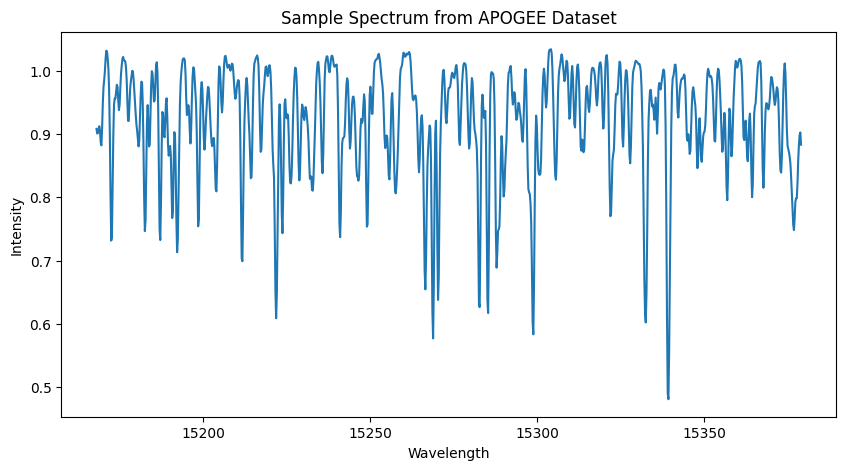

In [31]:
# Plot a portion of the normalized spectrum for the first star
# We are taking only the first 1000 data points for easier visualization
plt.figure(figsize=(10, 5)) 
plt.plot(wavelength[:1000], spectra[0][:1000])

# Adding labels and title for better understanding of the plot
plt.xlabel('Wavelength')
plt.ylabel('Intensity')
plt.title('Sample Spectrum from APOGEE Dataset')

# Show the plot
plt.show()

Great! Now you are taking the visualization a step further by introducing the Kiel diagram, which will help the audience understand the distribution of the stars in your dataset in terms of effective temperature (`Teff`), surface gravity (`logg`), and metallicity (`feh`). Here's how you can elaborate:

---

### What is the Kiel Diagram?

The Kiel diagram is a scatter plot that shows the relationship between the effective temperature and the surface gravity of stars. In our case, we'll add a twist by color-coding each point by the star's metallicity, offering a three-dimensional view of the data.

### Why APOGEE Lacks Dwarf Stars?

Before diving into the code, it's worth noting why there are fewer dwarf stars in our APOGEE dataset:

1. **Pipeline Focus**: The APOGEE pipeline is primarily designed to work on giant stars.
  
2. **Infrared Survey**: APOGEE aims to study regions far into the galactic disk, making it less conducive for studying nearby dwarf stars.
  
3. **Quality Cut**: Since we focus on high-quality (high SNR) data, many dwarf stars are excluded because they are generally fainter and thus produce lower-quality spectra.


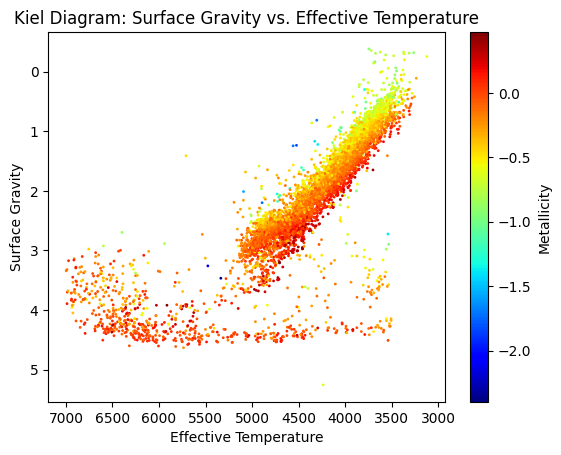

In [32]:
# Create a scatter plot of Surface Gravity vs Effective Temperature, color-coded by Metallicity
plt.scatter(teff_array, logg_array, c=feh_array, cmap='jet', s=1)

# Label axes and add a title
plt.xlabel('Effective Temperature')
plt.ylabel('Surface Gravity')
plt.title('Kiel Diagram: Surface Gravity vs. Effective Temperature')
plt.colorbar(label='Metallicity')

# Invert the x and y axes for traditional presentation
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

## Beginning with Simple Linear Regression

We will kick-start our analysis using a straightforward linear regression model, treating the spectra as the input $\mathbf{x}$ and the effective temperature as the target $y$. 

#### Assumptions:

1. **Noise-Free Inputs**: Following the derivation in the classroom, we will assume that $\mathbf{x}$ is noise-free for this exercise. For this reason, we've chosen APOGEE spectra that boast a Signal-to-Noise Ratio (SNR) of at least 50 for even the worst pixel.
  
2. **Limited Input Features**: We will use only the first 2000 pixels of each spectrum to avoid under-constraining the model, given that we have 6500 training spectra.

#### Why These Assumptions?

1. **SNR**: Higher SNR enables us to approximate noise-free observations, aiding simpler models.
  
2. **Limited Features**: Constraining the feature space is necessary to prevent overfitting, especially when the number of training examples is limited.

#### Future Exploration later

It's worth noting that the assumption of noiseless $\mathbf{x}$ values is a significant limitation in real-world applications. Most observations, even those with high SNR, will have some level of noise. In later exercises, we will delve deeper into the complexities of handling noisy observations for both $x$ and $y$, providing a more realistic modeling scenario.

### The Role of the Bias Term

In machine learning, the bias term allows the model to have more flexibility by not forcing the fitted line (or hyperplane in higher dimensions) to pass through the origin. This makes the model better suited to capture underlying trends in the data that do not originate from zero.


In [33]:
# Use spectra as the design matrix and limit to first 2000 pixels
Phi = spectra[:,:2000]

# Add a column of ones to the design matrix to act as the bias term
Phi = np.hstack((Phi, np.ones((Phi.shape[0], 1))))
print("Shape of design matrix Phi:", Phi.shape)

# Use effective temperature as the target variable
t = teff_array
print("Shape of target array t:", t.shape)

Shape of design matrix Phi: (6500, 2001)
Shape of target array t: (6500,)


## Data Splitting: Training, Validation, and Test Sets

### Importance of Data Splitting

In machine learning, it's common to divide the dataset into multiple parts:

- **Training Set**: Used to train the model.
- **Test Set**: Used to evaluate the model's generalization ability.
  
#### What About a Validation Set?

- **Validation Set**: Sometimes, a third set called the validation set is also used. This set helps in fine-tuning model parameters and selecting the best-performing model before final evaluation on the test set.

The validation set serves as an intermediate check during model training, offering insights into how different configurations or hyperparameters might affect the model's performance on unseen data. It allows for a more robust model selection process.

Here, we are focusing only on training and test sets for simple beginnings. However, in more complex projects, especially those involving hyperparameter tuning or model selection, a validation set is highly recommended.


In [34]:
# Import the train_test_split function from sklearn
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
Phi_train, Phi_test, t_train, t_test = train_test_split(Phi, t, test_size=0.2)

Excellent! Now that you've prepared your training and test sets, it's time to dive into the actual model fitting. The cell introduces the formula for computing the weights for linear regression using Maximum Likelihood Estimation (MLE), under certain assumptions.

---

## Maximum Likelihood Estimation in Linear Regression

The analytical solution for finding the optimal weights $\mathbf{w}$ in linear regression assumes that:

1. **Homogeneous Noise**: The noise in the output $ y $ is homogeneous, meaning it has the same variance across all levels of input.
2. **Noiseless Inputs**: In this example, we also assume that the input features $ x $, or here the spectrum are noiseless, or at least, have a high Signal-to-Noise Ratio (SNR).

Under these assumptions, the analytical formula to find the Maximum Likelihood (ML) weights is:

$$
\mathbf{w}_{\mathrm{ML}} = (\mathbf{\Phi_{\mathrm{train}}}^T \mathbf{\Phi_{\mathrm{train}}})^{-1} \mathbf{\Phi_{\mathrm{train}}}^T \mathbf{t_{\mathrm{train}}}
$$

This is often termed the "Normal Equation" in the context of linear regression.

This analytical solution is computationally efficient and gives us an exact answer, assuming the design matrix $ \Phi $ is full-rank, i.e., its columns are linearly independent.



In [35]:
# Compute the Maximum Likelihood weights using the analytical solution
w_ml = np.linalg.inv(Phi_train.T @ Phi_train) @ Phi_train.T @ t_train

Fantastic, you're at the crucial step of testing the trained linear regression model on the test set. This part will provide insight into the model's performance and its generalizability to unseen data.

---

## Testing the Model on Unseen Data

After training our model, the ultimate test of its quality is how well it performs on data it hasn't seen before. This is what the test set is for. We will use the trained model to make predictions $ t_{\mathrm{pred}} $ and compare these to the actual values $ t_{\mathrm{test}} $ in the test set.

To make predictions on the test set, we use the following equation:

$$
\mathbf{t}_{\mathrm{pred}} = \mathbf{\Phi}_{\mathrm{test}} \mathbf{w}_{\mathrm{ML}}
$$

where $ \mathbf{\Phi}_{\mathrm{test}} $ is the design matrix for the test set, and $ \mathbf{w}_{\mathrm{ML}} $ are the Maximum Likelihood weights we just computed.


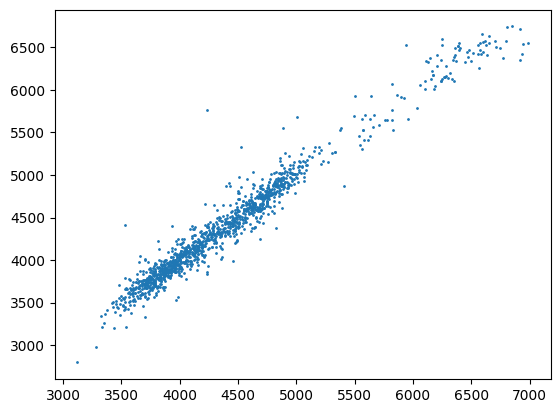

In [36]:
# Make predictions on the test set using the ML weights
t_pred = Phi_test @ w_ml

# Plot the actual vs predicted values
plt.scatter(t_test, t_pred, s=1)

Great, now that you have made your predictions, it's time to quantify the model's performance. This will help you understand how well your model is generalizing to unseen data and how it's performing on the training data it has seen.

---

## Evaluating Model Performance

One common way to measure the performance of a regression model is by calculating the Root Mean Square Error (RMSE). The RMSE gives us an idea of how well our model's predictions match the actual data points. Lower RMSE values indicate a better fit, but remember, a lower RMSE on the training set alone is not necessarily good; we also need a low RMSE on the test set to show that our model generalizes well.

The RMSE is defined as:

$$
\mathrm{RMSE} = \sqrt{\dfrac{1}{N}\sum_{i=1}^{N}(y_{\mathrm{true}, i} - y_{\mathrm{pred}, i})^2}
$$

where $N$ is the number of data points, $y_{\mathrm{true}, i}$ is the true value of the target variable for the $i$th data point, and $y_{\mathrm{pred}, i}$ is the predicted value of the target variable for the i-th data point.


In [37]:
# Calculate the RMSE for the training and test sets
train_RMSE = np.sqrt(np.mean((t_train - Phi_train @ w_ml)**2))
test_RMSE = np.sqrt(np.mean((t_test - t_pred)**2))

# Display the RMSE values
print("Training RMSE: {:.2f}".format(train_RMSE))
print("Test RMSE: {:.2f}".format(test_RMSE))

Training RMSE: 71.12
Test RMSE: 138.78


Excellent! You've reached an important milestone. Your model already shows promising results with a precision of around 130K for the effective temperature (Teff), which is an impressive feat given the simplified approach you've taken.

---

## Reflections on Our Initial Results

1. **Fraction of Pixels Used**: Keep in mind that we're using only about 1/3 of the available pixels in each spectrum. This reduced dimensionality could lead to less accurate models, yet we are still achieving good precision.

2. **Benchmarking**: When compared with established surveys like APOGEE and GALAH, which typically achieve a precision of around 50K, our straightforward model is not far off the mark.

In the following parts of this notebook, we will introduce advanced regularization methods and delve deeper into Bayesian techniques to push the boundaries of what our model can achieve.


---

## Exploring the Effect of Regularization

#### Regularization and its Purpose

Before diving into the code, let's talk briefly about why regularization might be useful. In machine learning, the objective is not just to fit the training data well but also to generalize to new, unseen data. A model that simply memorizes the training data can perform poorly on new data. This phenomenon is known as overfitting.

Regularization techniques introduce additional constraints into the model training process that discourage overfitting. Essentially, they impose a "cost" on the complexity of the model, encouraging simpler models unless the data strongly supports a more complicated one.

#### Regularized Maximum Likelihood Solution

In lecture, we covered that under a zero-mean Gaussian prior for the weights with a dispersion of $ \eta $, the posterior for the weights can be obtained analytically. In particular, assuming the regularization term $ \lambda $ is $ \sigma^2 / \eta^2 $.

Given a design matrix $ \Phi $ and target vector $ t $, the mean $ \mathbf{m}_N $ of the posterior for a regularized linear regression model is given by:

$$
\mathbf{m}_N = ( \lambda \mathbf{I} + \Phi_{\mathrm{train}}^T \Phi_{\mathrm{train}} )^{-1} \Phi_{\mathrm{train}}^T t_{\mathrm{train}}
$$

This equation effectively combines the likelihood term $ \Phi_{\mathrm{train}}^T \Phi_{\mathrm{train}} $ and the regularization term $ \lambda \mathbf{I} $ into a single expression, capturing the essence of a regularized solution.


In [38]:
# Define a function to calculate mean of the posterior for a regularized linear regression
def w_ml_regularised(l):
    return np.linalg.inv(l * np.eye(Phi_train.shape[1]) + Phi_train.T @ Phi_train) @ Phi_train.T @ t_train

Here we've picked a large value for $ \lambda $ to see how it affects the weights. When $ \lambda $ is large, we expect the weights to shrink toward zero, a phenomenon you can observe by comparing the norms `np.linalg.norm(w_ml)` and `np.linalg.norm(w_reg)`.

Regularization offers a controlled way to "shrink" weights, allowing the model to focus on the most important features while ignoring the noise.

In [39]:
# Choose a large lambda for the sake of this demonstration
l = 10 
w_reg = w_ml_regularised(l)

# Calculate norms of unregularized and regularized weights
np.linalg.norm(w_ml), np.linalg.norm(w_reg)

(133929.8392224054, 2909.68497256077)

### Performing Hyperparameter Tuning

#### Why Hyperparameter Tuning?

Machine learning models often contain hyperparameters that are not learned from the data but must be set prior to the training process. Choosing the right hyperparameters can be crucial for the performance of the model. In our case, the hyperparameter is $ \lambda $, which balances the complexity of the model.

We will perform grid search to explore a range of $ \lambda $ values on a logarithmic scale from $-2$ to $2$. For each value of $ \lambda $, we will train our regularized model and calculate the Root Mean Square Error (RMSE) for both the training and test sets.

After running the above code, you'll get a plot that shows the RMSE values for both the training and test sets as $\lambda$ varies. The objective is to find the value of $\lambda$ that gives the lowest RMSE for the test set without significantly increasing the training error. This would indicate a well-generalized model.



Training model for log lambda = -2.00
Training model for log lambda = -1.73
Training model for log lambda = -1.47
Training model for log lambda = -1.20
Training model for log lambda = -0.93
Training model for log lambda = -0.67
Training model for log lambda = -0.40
Training model for log lambda = -0.13
Training model for log lambda = 0.13
Training model for log lambda = 0.40
Training model for log lambda = 0.67
Training model for log lambda = 0.93
Training model for log lambda = 1.20
Training model for log lambda = 1.47
Training model for log lambda = 1.73
Training model for log lambda = 2.00


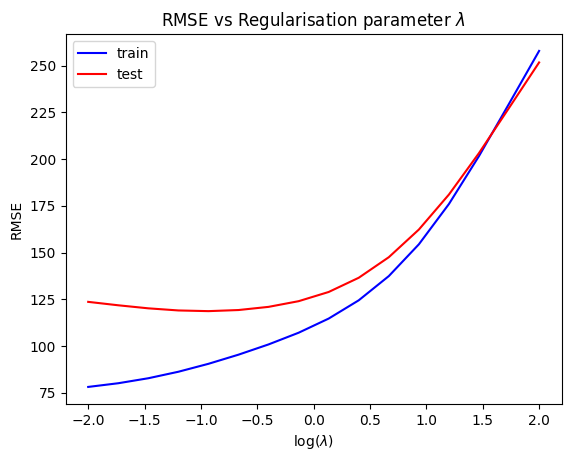

In [40]:
# Define a range of log-scaled lambda values
log_lambdas = np.linspace(-2, 2, 16)

# Initialize an array to store the results. 
# The first column will contain RMSE for training data and the second for test data.
results = np.zeros((len(log_lambdas), 2))

# Loop over each hyperparameter value and train the model
for ix, l in enumerate(log_lambdas):
    print("Training model for log lambda = {:.2f}".format(float(l)))

    # Compute the regularized weight vector
    w_reg = w_ml_regularised(pow(10,float(l)))

    # Calculate RMSE for training and test sets
    rmse_train = np.sqrt(np.mean((t_train - Phi_train @ w_reg)**2))
    rmse_test = np.sqrt(np.mean((t_test - Phi_test @ w_reg)**2))

    # Store the results
    results[ix, 0] = rmse_train
    results[ix, 1] = rmse_test

# Plot the RMSE values as a function of lambda
plt.title('RMSE vs Regularisation parameter $\lambda$')
plt.plot(log_lambdas, results[:,0], 'b-', label='train')  # Training data
plt.plot(log_lambdas, results[:,1], 'r-', label='test')  # Test data
plt.xlabel('log($\lambda$)')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [41]:
# the best RMSE is achieved at the minimum of the test curve
best_lambda = pow(10, log_lambdas[np.argmin(results[:,1])])
print("Best lambda: {:.2f}".format(best_lambda))
print("Best test RMSE: {:.2f}".format(np.min(results[:,1])))

Best lambda: 0.12
Best test RMSE: 118.64


Congratulations on successfully applying regularization to your machine learning model! As you've noticed, the performance has improved significantly. The Root Mean Square Error (RMSE) for predicting effective temperature $T_{\mathrm{eff}}$ has been reduced to 100K, an excellent achievement.

The reduction in RMSE indicates that the model is now more accurate in its predictions. This success demonstrates the utility of incorporating regularization into your machine learning pipeline. The regularization term $ \lambda $ added a constraint that penalized overly complex models, enabling the algorithm to focus on the most important features in the data. The result is a more generalizable model that performs better not just on the data it was trained on, but also on new, unseen data.

Improving prediction accuracy is often the main goal in machine learning applications. The fact that a simple regularization technique could significantly enhance the model's performance is a big win. This exercise underscores the importance of fine-tuning your models and exploring advanced techniques to get the best out of your data.


--- 

### Extending Linear Models with Basis Functions

Before we dive into the code, let's explore what basis functions are and why they're important. In machine learning, a basis function transforms the input data into a more suitable form for a particular learning algorithm. Essentially, it takes our input $ \mathbf{x} $ and maps it into another space, $ \phi(\mathbf{x}) $, that might be more useful for the task at hand.

The reason we might use basis functions is that, although linear regression models are linear in their parameters, they don't have to be linear in their features. This means you can apply all sorts of transformations to your input data and still use a linear model to fit the transformed data.

In the code snippet below, a quadratic basis function is defined. It transforms each original feature $ \mathbf{x} $ in the input into a set of features $[\mathbf{x}, \mathbf{x}^2]$. This allows the linear model to capture nonlinear relationships between the features and the target variable while still remaining linear in its parameters.

#### Importance of Domain Knowledge

In the real world, the choice of basis function often depends on the specific problem and your understanding of the data. For example, in the lecture, we saw the Kennicutt-Schmidt Law, which could be seen as a type of basis function for that particular problem. 

While basis functions offer a powerful way to extend linear models, they do require manual intervention in choosing the right function, which can be labor-intensive. When we cover Neural Networks and Gaussian Processes in upcoming sections, you'll see how these methods can implicitly define the best basis function for you, automating much of this process.


In [42]:
def phi_quadratic(x):    
    return np.hstack((x, x**2))

We will start with the case without regularisation.

In [43]:
# Extend the feature set
Phi_quad_train = np.array([phi_quadratic(Phi_train[i]) for i in range(Phi_train.shape[0])])
Phi_quad_test = np.array([phi_quadratic(Phi_test[i]) for i in range(Phi_test.shape[0])])

# Remove the extra bias term
Phi_quad_train = Phi_quad_train[:,:-1]
Phi_quad_test = Phi_quad_test[:,:-1]

# Train the model
w_unreg = np.linalg.inv(Phi_quad_train.T @ Phi_quad_train) @ Phi_quad_train.T @ t_train
t_train_pred = np.dot(Phi_quad_train, w_unreg)
t_test_pred = np.dot(Phi_quad_test, w_unreg)

# Calculate RMSE
train_rmse = np.sqrt(np.mean((t_train - t_train_pred)**2))
test_rmse = np.sqrt(np.mean((t_test - t_test_pred)**2))

print("RMSE with basis functions and without regularisation: Train {:.2f}, Test {:.2f}".format(train_rmse, test_rmse))

RMSE with basis functions and without regularisation: Train 16.52, Test 205.85


We've just seen how the addition of quadratic features to our linear model improved the training RMSE but worsened the test RMSE—a classic sign of overfitting. This is where regularization can play a significant role, especially when the feature space expands.

We will apply regularization to the linear regression model with quadratic features:


Training model for log lambda = -2.00


Training model for log lambda = -1.73
Training model for log lambda = -1.47
Training model for log lambda = -1.20
Training model for log lambda = -0.93
Training model for log lambda = -0.67
Training model for log lambda = -0.40
Training model for log lambda = -0.13
Training model for log lambda = 0.13
Training model for log lambda = 0.40
Training model for log lambda = 0.67
Training model for log lambda = 0.93
Training model for log lambda = 1.20
Training model for log lambda = 1.47
Training model for log lambda = 1.73
Training model for log lambda = 2.00


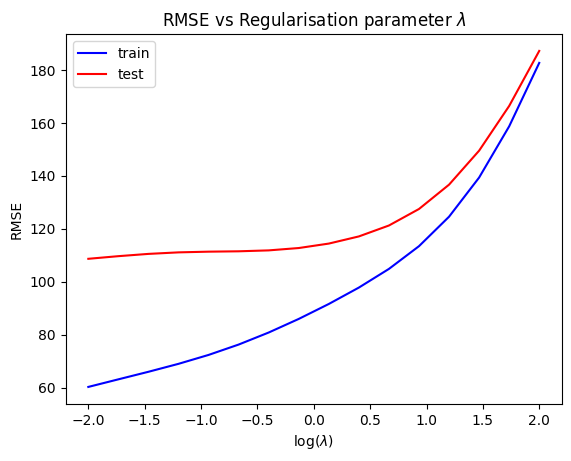

In [44]:
# Function to calculate the weight vector for a regularized linear regression
def w_ml_regularised(l):
    return np.linalg.inv(l * np.eye(Phi_quad_train.shape[1]) + Phi_quad_train.T @ Phi_quad_train) @ Phi_quad_train.T @ t_train

# Initialize the search grid for lambda values
log_lambdas = np.linspace(-2, 2, 16)
results = np.zeros((len(log_lambdas), 2))

# Perform grid search
for ix, l in enumerate(log_lambdas):
    print("Training model for log lambda = {:.2f}".format(float(l)))
    w_reg = w_ml_regularised(pow(10,float(l)))
    rmse_train = np.sqrt(np.mean((t_train - Phi_quad_train @ w_reg)**2))
    rmse_test = np.sqrt(np.mean((t_test - Phi_quad_test @ w_reg)**2))
    results[ix, 0] = rmse_train
    results[ix, 1] = rmse_test

# Plotting
plt.title('RMSE vs Regularisation parameter $\\lambda$')
plt.plot(log_lambdas, results[:,0], 'b-', label='train')
plt.plot(log_lambdas, results[:,1], 'r-', label='test')
plt.xlabel('log($\\lambda$)')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [45]:
# the best RMSE is achieved at the minimum of the test curve
best_lambda = pow(10, log_lambdas[np.argmin(results[:,1])])
print("Best lambda: {:.2f}".format(best_lambda))
print("Best test RMSE: {:.2f}".format(np.min(results[:,1])))

Best lambda: 0.01
Best test RMSE: 108.65


We find that although it does mitigate the problem of overfitting to some extent, it doesn't offer a significant improvement in test RMSE compared to the original linear model. This suggests that the addition of quadratic features might not be that beneficial for this specific problem. 

Therefore, for this particular application, it seems that the original linear model without quadratic basis functions is the better choice. This exercise serves as a valuable lesson in model selection and the importance of interpreting the results in context, rather than merely following the numbers.

Sometimes, the simplest model is the best model.

---

### Predictive Distribution for Regularized Bayesian Linear Regression

In Bayesian linear regression with regularization, we don't just find a single "best-fit" line; we consider a distribution over possible lines, factoring in model uncertainty. This allows us to make probabilistic statements about our predictions.

In particular, given the posterior distribution of the model $ p(\mathbf{w} | \mathcal{D}) $, the predictive distribution for a new test input $ \mathbf{x}_* $ given a training set $ \mathcal{D} $ is:

$$
p(y_* | \mathbf{x}_*, \mathcal{D}) = \int p(y_* | \mathbf{x}_*, \mathbf{w}) p(\mathbf{w} | \mathcal{D}) d\mathbf{w}
$$

Here, $ p(y_* | \mathbf{x}_*, \mathbf{w}) $ is the likelihood of the test data given the weights, and $ p(\mathbf{w} | \mathcal{D}) $ is the posterior distribution of the weights given the training data. In other words, we marginalize over model uncertainty.

In Bayesian linear regression with a Gaussian prior and regularization, this integral has a closed-form solution. The predictive distribution becomes Gaussian with mean $ \mu = \Phi_*^T \mathbf{m_N}$ and variance $ \sigma^2 = \beta^{-1} + \Phi_*^T \mathbf{S}_N \Phi_* $, where $ \mathbf{S}_N $ is the covariance of the posterior distribution of $ \mathbf{w} $, 

$$
\mathbf{S} = ( \lambda \mathbf{I} + \beta \Phi_{\mathrm{train}}^T \Phi_{\mathrm{train}} )^{-1}
$$

and $ \beta $ is the inverse variance of the observed noise. We can estimate $ \beta $ (the noise precision, which is the inverse of the noise variance) as the maximum likelihood $\beta_{\mathrm{ML}}$ as discussed in the lecture:

$$
\dfrac{1}{\beta_{\mathrm{ML}}} = \dfrac{1}{N} {\sum_{n=1}^{N} \Big (t_n - \mathbf{m_N}^T \phi(\mathbf{x}_n) \Big)^2}
$$

Here, $ N $ is the number of training samples, $ t_n $ is the true output for the $ n $-th training sample, and $ \phi(\mathbf{x}_n) $ is the feature vector for the $ n $-th training sample.

In the accompanying implementation, the `pred_means` array gives you the most likely effective temperature for each data point in the test set, while `pred_vars` provides a measure of the uncertainty in those predictions. This capability to quantify uncertainty is one of the powerful aspects of Bayesian methods: you receive not only a prediction but also a measure of how certain you are about that prediction. And remarkably, in the case of regularized Bayesian linear regression, all calculations remain analytical.

In [46]:
# Define regularization parameter lambda 
# we use the best_lambda value from the above 
lambda_reg = 0.22

# Compute regularized w_ml
m_N = np.linalg.inv(lambda_reg * np.eye(Phi_train.shape[1]) + Phi_train.T @ Phi_train) @ Phi_train.T @ t_train

# Assuming the noise precision beta is estimated as:
N = len(t_train)
beta = N / np.sum((t_train - Phi_train @ m_N)**2)

# Compute the posterior covariance S with regularization
S_inv = Phi_train.T @ Phi_train + (1/beta + lambda_reg) * np.eye(Phi_train.shape[1])
S_N = np.linalg.inv(S_inv)

# Initialize arrays for predictive means and variances
pred_means = np.zeros(Phi_test.shape[0])
pred_vars = np.zeros(Phi_test.shape[0])

# Calculate the predictive distributions for the test set
for i in range(Phi_test.shape[0]):
    pred_means[i] = Phi_test[i] @ m_N
    pred_vars[i] = 1/beta + Phi_test[i].T @ S_N @ Phi_test[i]

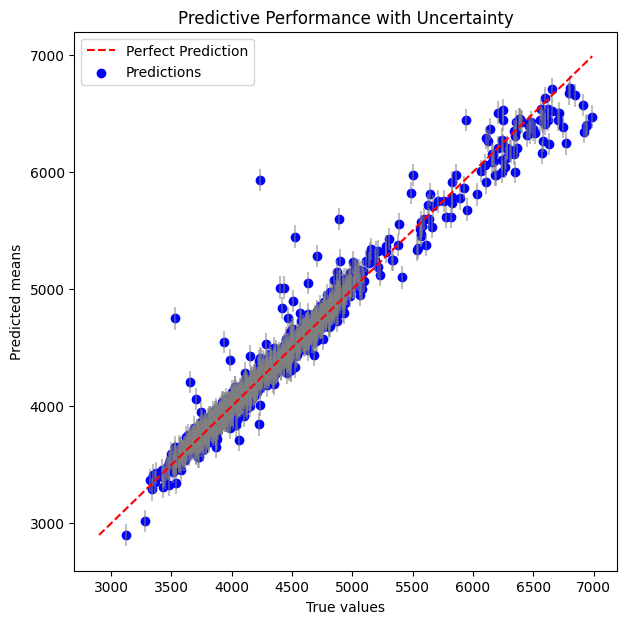

In [47]:
# Convert predictive variance to standard deviation for plotting
pred_stds = np.sqrt(pred_vars)

# Create scatter plot
plt.figure(figsize=(7, 7))
plt.scatter(t_test, pred_means, c='blue', marker='o', label='Predictions')

# Add error bars to indicate predictive uncertainty
plt.errorbar(t_test, pred_means, yerr=pred_stds, fmt='none', ecolor='gray', alpha=0.5)

# Plot a line for perfect predictions
min_val = min(np.min(t_test), np.min(pred_means))
max_val = max(np.max(t_test), np.max(pred_means))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

# Add labels and legend
plt.xlabel('True values')
plt.ylabel('Predicted means')
plt.title('Predictive Performance with Uncertainty')
plt.legend()

As shown above, our predictive distribution largely succeeds in expressing uncertainty. When it indicates uncertainty about a prediction, the true value often does lie within the predicted interval.

However, when the noise variance $ \beta^{-1} $ dominates over model uncertainty (represented by $ S_N $), we observe that the predictive uncertainty becomes fairly constant across different points. This key observation informs us that much of our uncertainty arises from noise in the data rather than from the model's flexibility.

A caveat to the model's predictive power is its tendency to underestimate the uncertainty associated with outliers. This limitation largely stems from the Gaussian assumptions made about the noise, the prior, and, subsequently, the posterior predictive distribution, which are not well-suited for handling outliers. And hence this underestimation becomes more pronounced for handling outliers.

----

#### Closing Remarks:

This tutorial has provided you with a comprehensive understanding of linear regression within a Bayesian framework. We covered everything from the basic setup and overfitting prevention through regularization to making probabilistic predictions. While Bayesian Linear Regression offers many advantages, such as well-calibrated uncertainty estimates, it is essential to recognize its limitations, especially when your data violate model assumptions or when dealing with complex, non-linear phenomena.

We have learned that:

1. **Feature Engineering**: We experimented with different basis functions and identified the need for regularization, particularly in high-dimensional settings.
  
2. **Regularization**: Through hyperparameter tuning, we discovered that regularization effectively prevents overfitting and can influence predictive uncertainty.
  
3. **Predictive Distributions**: Bayesian linear regression provides not only point estimates but also measures of uncertainty, invaluable in real-world applications for risk assessment.
  
4. **Model Limitations**: Every model comes with its own set of assumptions and limitations. For instance, the Gaussian assumption in this model may not be ideal for handling outliers.
  
5. **Analytical Solutions**: One of the appealing features of Bayesian linear regression is the ability to compute much of it analytically, enhancing computational efficiency.
